# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Multicolinearity](#Multicolinearity)
- [Modeling](#Modeling)
    - [K-Means](#K-Means)

# Libraries 

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [158]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity

In [159]:
vif_data = pd.DataFrame()
vif_data["feature"] = pitch_data.columns

vif_data["VIF"] = [variance_inflation_factor(pitch_data.values, i)
                          for i in range(len(pitch_data.columns))]

vif_data.sort_values(by = 'VIF').head(20)

,feature,VIF
15,cg,1.364100
1,age,1.365355
81,cu_hb,1.527192
41,edge%,1.624982
29,solid_contact%,1.835575
30,poor_weak%,2.339208
60,sl_hb,2.433292
64,ch%,2.848569
74,cb_hb,2.861837
56,4seam_velo_range,2.870094


In [37]:
X = pitch_data[['age', 'edge%', 'poor_weak%', 'ch%', '4seam%', 
                'cu%', 'cb%', 'sl_brk', 'sl%', 
                'ev_avg', 'barrel%', 
                'cb_brk', 'ch_spinrate', 
                '4seam_spinrate', '4seam_velo']]
print(X.shape)
X.head()

(1072, 15)


,age,edge%,poor_weak%,ch%,4seam%,cu%,cb%,sl_brk,sl%,ev_avg,barrel%,cb_brk,ch_spinrate,4seam_spinrate,4seam_velo
player_id,,,,,,,,,,,,,,,
425794,40,44.8,3.2,6.3,9.3,22.2,34.5,0.0,0.0,88.3,6.1,22.3,1719.0,2229.0,89.1
425844,38,42.8,5.0,21.9,40.1,0.0,16.7,8.9,15.5,88.1,6.6,15.6,1590.0,2236.0,89.0
429722,39,40.1,4.8,3.2,45.3,0.0,0.0,5.4,51.5,89.8,10.8,0.0,1690.0,2179.0,93.4
433589,37,43.3,6.6,18.1,45.1,23.3,13.5,0.0,0.0,86.4,9.1,10.7,1751.0,2135.0,87.6
445276,34,40.9,11.5,0.0,0.0,57.1,0.0,9.1,15.5,84.3,4.3,0.0,0.0,0.0,0.0


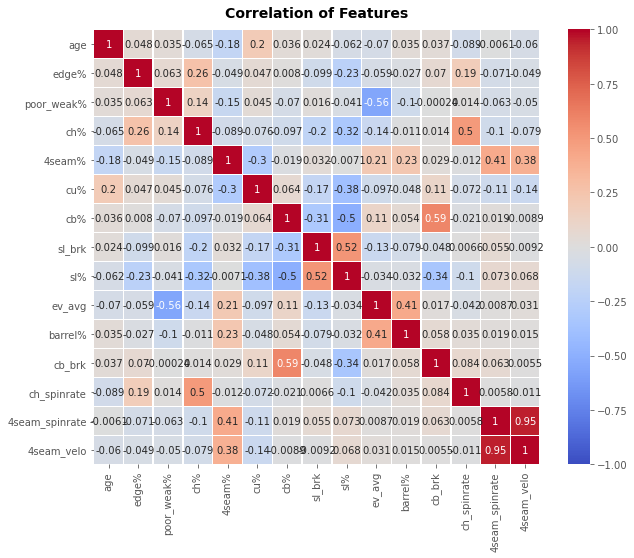

In [38]:
plt.figure(figsize = (10, 8))
sns.heatmap(X.corr(), annot = True,
            vmin = -1, 
            vmax = 1,
            linewidths = 0.5,
            cmap = 'coolwarm')
plt.title('Correlation of Features', 
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('heatmap.png')

In [160]:
X2 = pitch_data[['age', 'edge%', 'poor_weak%', '4seam%', 
                 '4seam_velo', 'ch%', 'cb%', 'sl%', 'cu%']]

# Modeling

### Standardize Data

In [161]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X2)

X_scaled[:,:] *= -1

### PCA

In [162]:
pca = PCA().fit(X_scaled)
principal_components = pca.transform(X_scaled)

[0.21694105 0.16203044 0.14960402 0.10897474 0.10234298 0.08906305
 0.08014498 0.06656694 0.02433182]


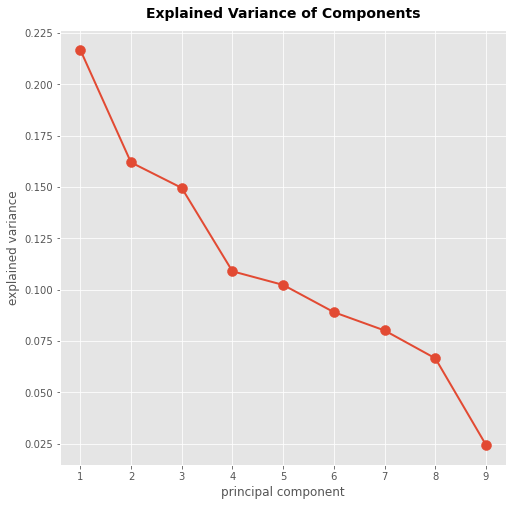

In [164]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(range(1, 10), pca.explained_variance_ratio_, lw = 2)
ax.scatter(range(1, 10), pca.explained_variance_ratio_, s = 100)
ax.set_title('Explained Variance of Components', fontsize = 14, 
             fontweight = 'bold', pad = 12)
ax.set_xlabel('principal component', fontsize = 12)
ax.set_ylabel('explained variance', fontsize = 12);
print(pca.explained_variance_ratio_)

#plt.savefig('explained varience ratio.png')

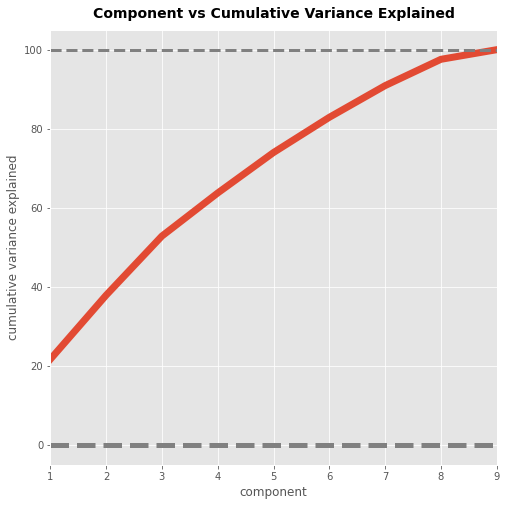

In [165]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8,8))
component_number = range(1, 10)
plt.plot(component_number, cum_var_exp, lw = 7)
plt.axhline(y = 0, linewidth = 5, color = 'grey', ls = 'dashed')
plt.axhline(y = 100, linewidth = 3, color = 'grey', ls = 'dashed')
ax = plt.gca()
ax.set_xlim([1, 9], auto = True)
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize = 12)
ax.set_xlabel('component', fontsize = 12)  
ax.set_title('Component vs Cumulative Variance Explained', 
             fontsize = 14, fontweight = 'bold', pad = 12);

#plt.savefig('component v. cumulative variance explained.png')

In [166]:
# this cell makes code for X break
#pca_component_1_eigenvec = pca.components_[0]

#for weight, X in zip(pca_component_1_eigenvec, 
#                     X.columns):
    
#    print(X, weight)

In [167]:
pitch_df = pd.DataFrame(data = principal_components, 
                        columns = X2.columns)

print(pitch_df.shape)
pitch_df.head()

(1072, 9)


,age,edge%,poor_weak%,4seam%,4seam_velo,ch%,cb%,sl%,cu%
0,2.934779,-0.120164,-2.016951,-1.430053,-1.031787,-1.638736,-0.026824,-0.638371,-0.198306
1,0.870585,-0.021394,0.139578,-1.377957,-0.415924,-1.793754,1.245117,0.367308,-0.399114
2,-1.641256,1.962919,-0.859741,-1.960721,-0.399781,-1.394553,0.949191,0.651291,-0.588225
3,1.984921,-0.116707,-0.141095,-1.889957,0.212770,-0.412625,0.740203,1.050551,-0.256455
4,3.867398,4.882333,-0.765574,0.422038,1.863744,0.763246,-0.781254,3.121196,-0.448082


### K-Means

In [168]:
inertias = []
mapping = {}
K = range(1, 21)
 
for k in K:
    km = KMeans(n_clusters=k).fit(X_scaled)
    km.fit(X_scaled)
 
    inertias.append(km.inertia_)

    mapping[k] = km.inertia_

In [169]:
# inertia
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 9648.000000000016
2 : 8266.692904107178
3 : 7159.362224992023
4 : 6459.974698250468
5 : 5853.298436125707
6 : 5465.622218622894
7 : 5216.184520985607
8 : 5007.477139868157
9 : 4836.614768699664
10 : 4703.635374730493
11 : 4536.640992503176
12 : 4410.929393365371
13 : 4286.696583455568
14 : 4178.80336501361
15 : 4056.566132864017
16 : 3981.2858354364935
17 : 3920.619213784975
18 : 3824.2242160584788
19 : 3742.82805108442
20 : 3698.0198499165567


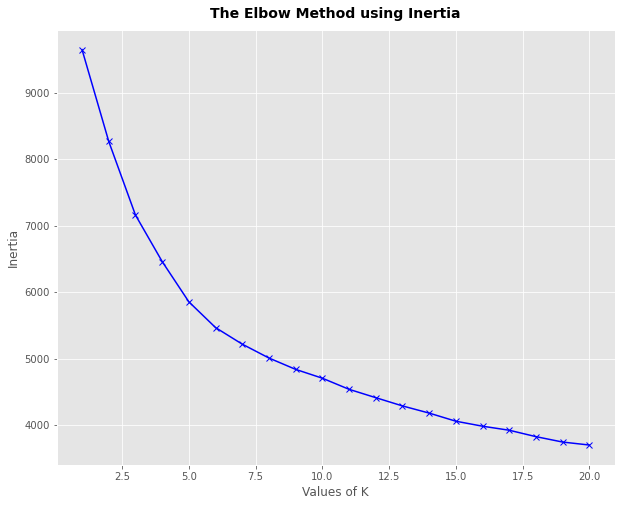

In [170]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
plt.figure(figsize = (10,8))

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('The Elbow Method using Inertia', fontsize = 14, fontweight = 'bold', pad = 12);

#plt.savefig('component v. cumulative variance explained.png')

In [185]:
km = KMeans(n_clusters = 5,
            random_state = 0)

km.fit(pitch_df)
label = km.fit_predict(pitch_df)

print(label)

[3 2 1 ... 0 2 1]


In [186]:
print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_df, label))

label: [3 2 1 ... 0 2 1]
Number of iterations: 20
Number of features: 9
Number of clusters: 5
Inertia: 5852.922146396333
Silhouette Score: 0.158153056780849


In [187]:
centroids = km.cluster_centers_
print("Predicted clusters to points: ", label[:10], '\n')
print('Location of centroids:', '\n')
print(centroids)

Predicted clusters to points:  [3 2 1 3 4 3 3 0 0 3] 

Location of centroids: 

[[ 1.64879114e-01 -1.26275419e+00 -8.53602703e-01  4.08872909e-01
   2.65361448e-01 -4.75839561e-01 -1.18921143e-01 -3.54800553e-02
   2.47165848e-03]
 [-1.33509775e+00  5.83977546e-01 -1.46232409e-01 -4.62248015e-02
  -4.24283330e-04 -1.30062306e-02 -5.24942629e-02 -6.70567335e-02
  -9.34807447e-03]
 [ 2.69189912e-01 -4.04811722e-01  1.16225096e+00 -2.56737465e-01
  -7.88721085e-02 -5.02351852e-02  2.07573148e-01 -2.32305302e-02
   1.45660872e-02]
 [ 1.64492443e+00  2.51598501e-01 -7.85735398e-01 -7.00025869e-01
  -3.56137693e-02  8.89915832e-01 -3.67374295e-02 -2.34892528e-01
  -2.08267681e-03]
 [ 2.59738470e+00  2.80234131e+00  2.40877315e-01  2.86995364e+00
  -5.72015418e-01 -6.49186653e-01 -2.79797848e-01  1.78623618e+00
  -2.40889169e-02]]


In [188]:
#centroids_x = centroids[:5, 0:3:2]
#centroids_y = centroids[:5, 1:4:2]
#print('y', centroids_y, '\n')
centroids_x = centroids[:, 0]
print('x:', centroids_x, '\n')
centroids_y = centroids[:, 1]
print('y:', centroids_y)

x: [ 0.16487911 -1.33509775  0.26918991  1.64492443  2.5973847 ] 

y: [-1.26275419  0.58397755 -0.40481172  0.2515985   2.80234131]


In [189]:
X2['label'] = label
pitch_data['label'] = label
pitch_df['label'] = label
pitch_df.head()

,age,edge%,poor_weak%,4seam%,4seam_velo,ch%,cb%,sl%,cu%,label
0,2.934779,-0.120164,-2.016951,-1.430053,-1.031787,-1.638736,-0.026824,-0.638371,-0.198306,3
1,0.870585,-0.021394,0.139578,-1.377957,-0.415924,-1.793754,1.245117,0.367308,-0.399114,2
2,-1.641256,1.962919,-0.859741,-1.960721,-0.399781,-1.394553,0.949191,0.651291,-0.588225,1
3,1.984921,-0.116707,-0.141095,-1.889957,0.212770,-0.412625,0.740203,1.050551,-0.256455,3
4,3.867398,4.882333,-0.765574,0.422038,1.863744,0.763246,-0.781254,3.121196,-0.448082,4


In [190]:
pitch_df.groupby(by = 'label').mean().T

label,0,1,2,3,4
age,0.164879,-1.335098,0.269190,1.644924,2.597385
edge%,-1.262754,0.583978,-0.404812,0.251599,2.802341
poor_weak%,-0.853603,-0.146232,1.162251,-0.785735,0.240877
4seam%,0.408873,-0.046225,-0.256737,-0.700026,2.869954
4seam_velo,0.265361,-0.000424,-0.078872,-0.035614,-0.572015
ch%,-0.475840,-0.013006,-0.050235,0.889916,-0.649187
cb%,-0.118921,-0.052494,0.207573,-0.036737,-0.279798
sl%,-0.035480,-0.067057,-0.023231,-0.234893,1.786236
cu%,0.002472,-0.009348,0.014566,-0.002083,-0.024089


Cluster 0: likely all relievers, 0 ch %

Cluster 1: likely majority starters, high ch %

Cluster 2: Oldest group, likely majority starters, highest ch %

Cluster 3: youngest group, likely majority relievers, heavy fastball %

In [191]:
X2.groupby(by = 'label').mean().T

label,0,1,2,3,4
age,28.330049,28.576087,28.773649,31.222222,29.325581
edge%,42.015271,41.330978,43.809122,42.963580,42.683721
poor_weak%,3.520690,3.958696,4.938851,4.390123,4.674419
4seam%,44.269951,38.166033,38.440203,20.224691,0.000000
4seam_velo,93.520690,94.074457,92.962500,92.111111,0.000000
ch%,6.985222,5.055707,21.214865,9.579630,13.372093
cb%,25.791626,4.146196,7.354054,12.353086,10.134884
sl%,7.676847,33.986957,13.732095,5.137654,14.762791
cu%,3.877340,0.839946,2.941554,31.656790,15.265116


In [192]:
X3 = pitch_data[['age', 'edge%', 'poor_weak%', '4seam%', 
                 '4seam_velo', 'ch%', 'sl%','cu%', 'cb%', 'throws']]
X3['label'] = label
X3.groupby(by = 'label').mean().T

label,0,1,2,3,4
age,28.330049,28.576087,28.773649,31.222222,29.325581
edge%,42.015271,41.330978,43.809122,42.963580,42.683721
poor_weak%,3.520690,3.958696,4.938851,4.390123,4.674419
4seam%,44.269951,38.166033,38.440203,20.224691,0.000000
4seam_velo,93.520690,94.074457,92.962500,92.111111,0.000000
ch%,6.985222,5.055707,21.214865,9.579630,13.372093
sl%,7.676847,33.986957,13.732095,5.137654,14.762791
cu%,3.877340,0.839946,2.941554,31.656790,15.265116
cb%,25.791626,4.146196,7.354054,12.353086,10.134884
throws,0.733990,0.788043,0.692568,0.672840,0.534884


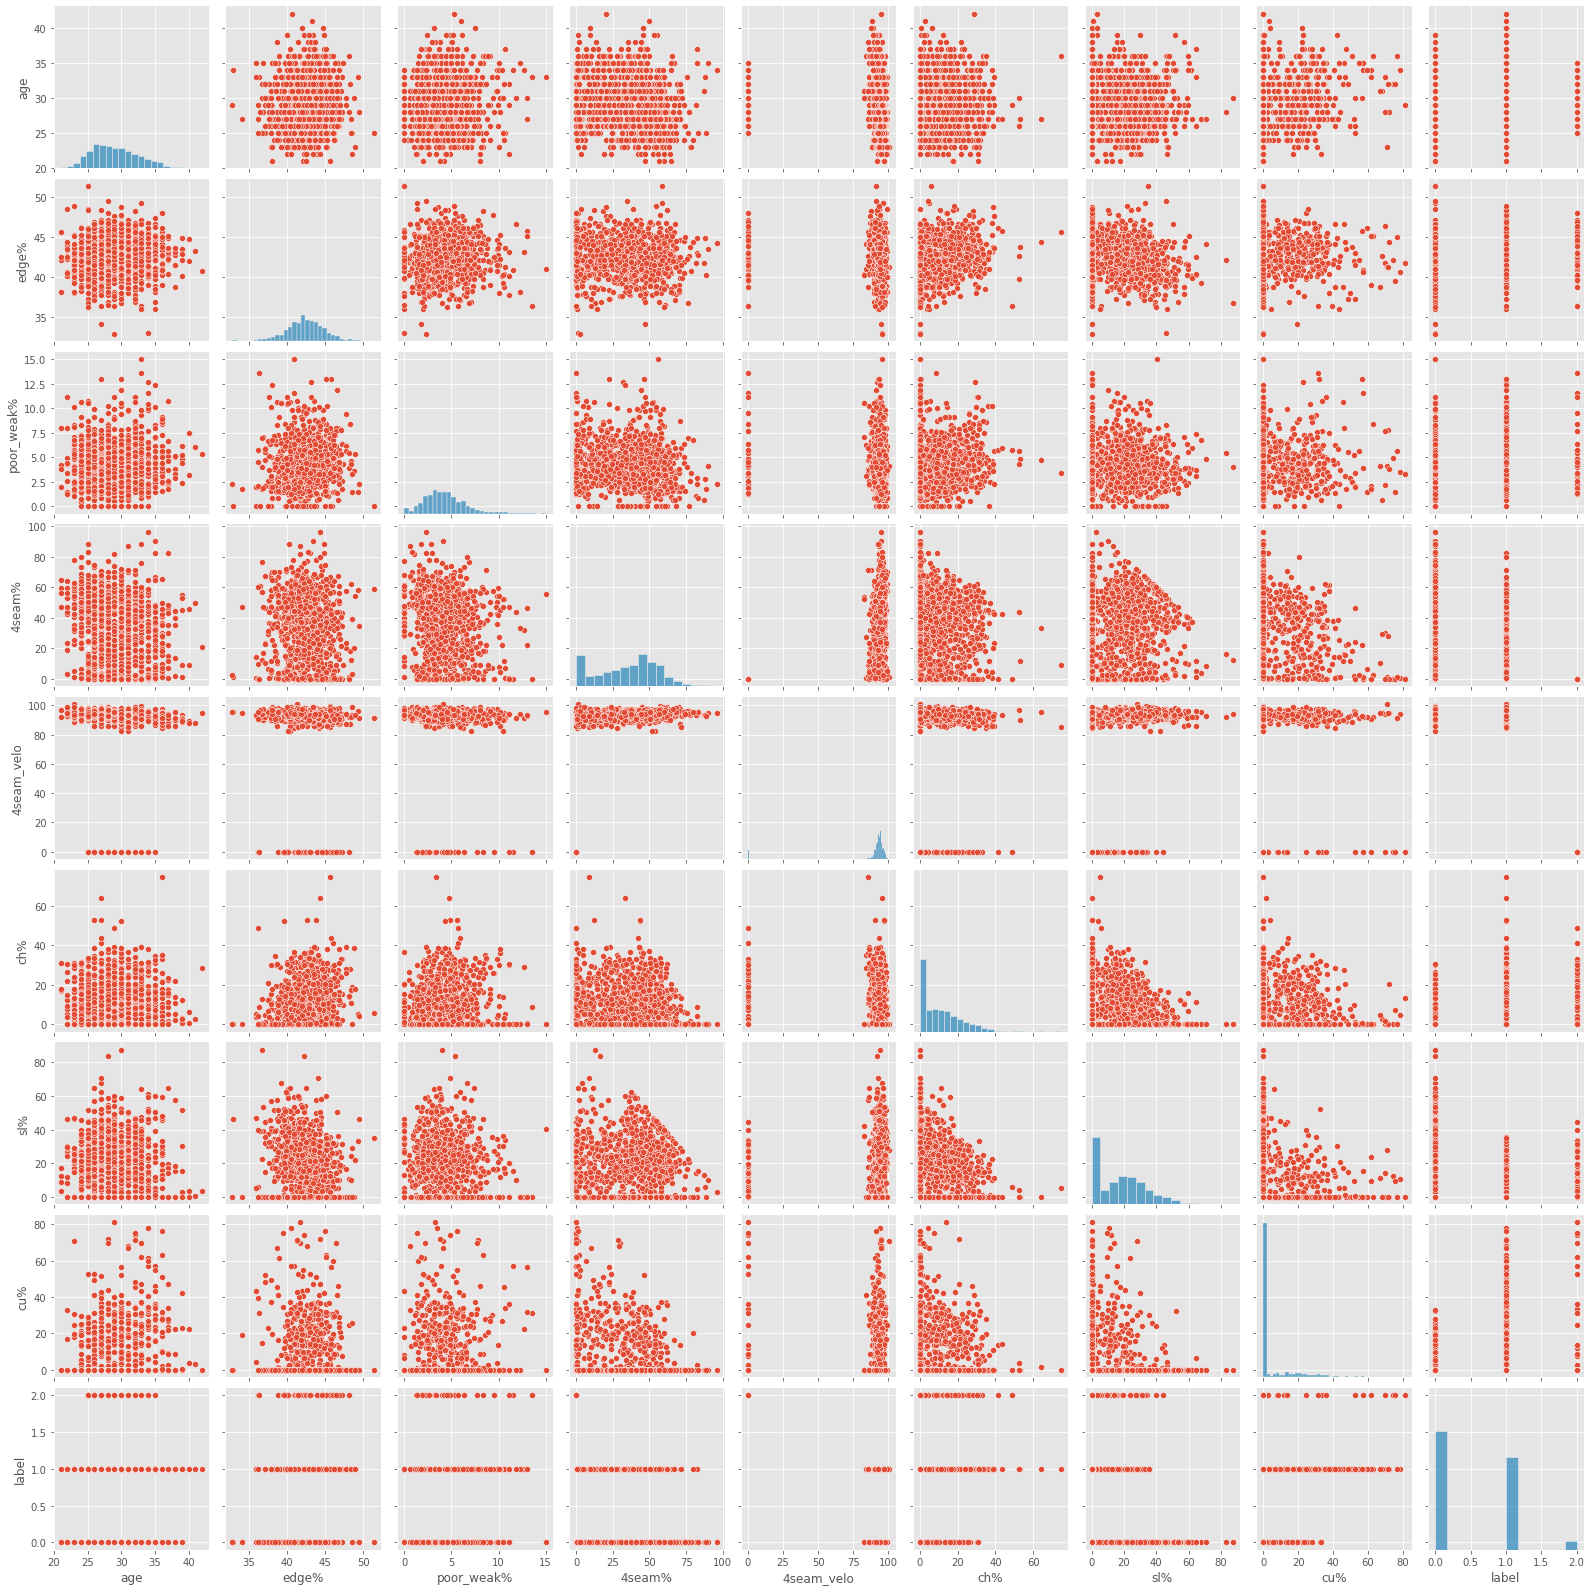

In [140]:
sns.pairplot(X2);

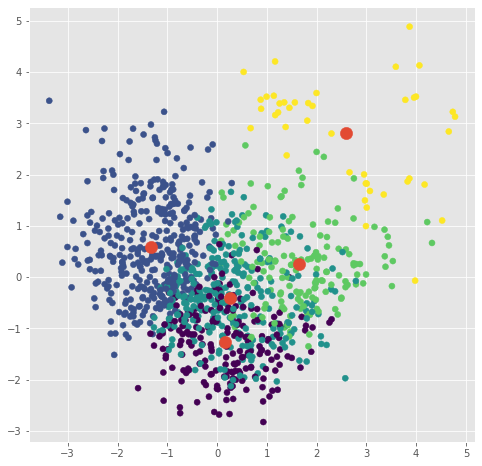

In [193]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['edge%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

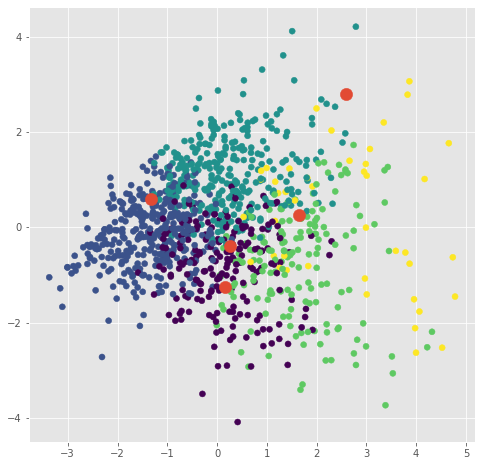

In [194]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['poor_weak%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

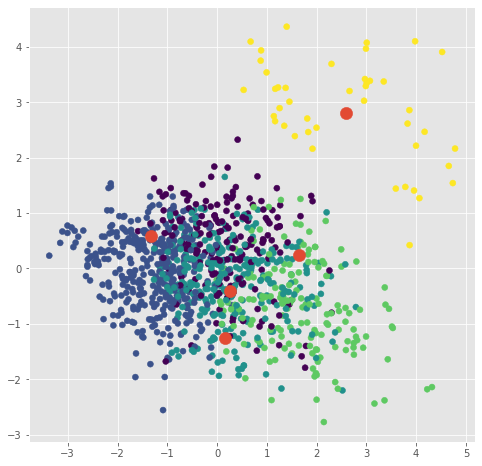

In [195]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['4seam%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

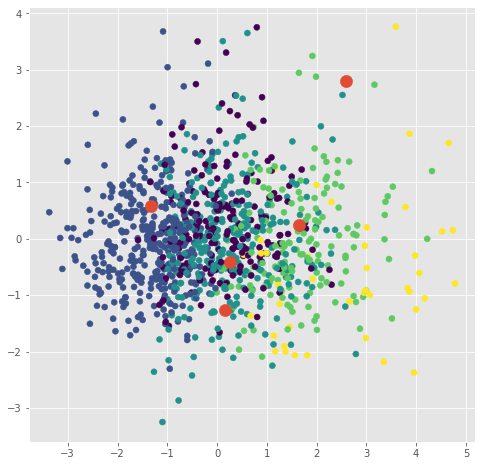

In [196]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

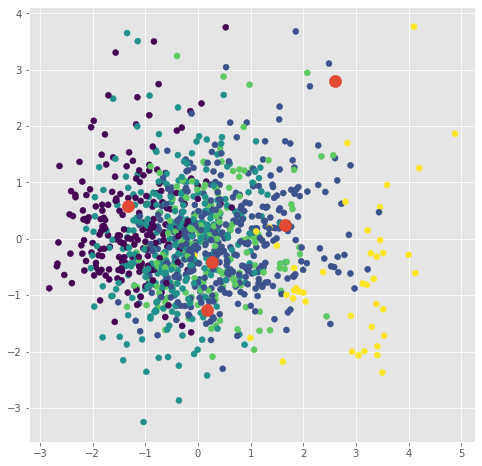

In [197]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['edge%'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

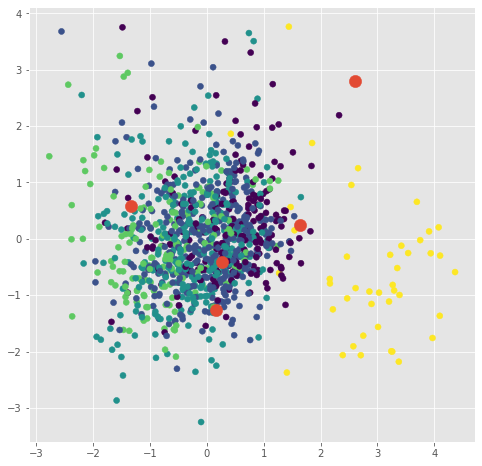

In [198]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['4seam%'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

In [31]:
#pitch_df = pitch_df.values
#plt.figure(figsize = (8,8))
#plt.scatter(pitch_df[label == 0, 0], pitch_df[label == 0, 1], c = 'red', label = 'Cluster 1')
#plt.scatter(pitch_df[label == 1, 0], pitch_df[label == 1, 1], c = 'blue', label = 'Cluster 2')
#plt.scatter(pitch_df[label == 2, 0], pitch_df[label == 2, 1], c = 'green', label = 'Cluster 3')
#plt.scatter(pitch_df[label == 3, 0], pitch_df[label == 3, 1], c = 'cyan', label = 'Cluster 4')
#plt.scatter(centroids_x, centroids_y, s = 150, c = 'yellow', label = 'Centroids');